In [134]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [147]:
class Deep_Neural_Network :

  def create(self,input_size,output_size,hidden_dims,output_type,initializer='random',
             seed=None,activation='relu',leaky_relu_slope=0.1):
    """
    The method to define the architecture of Deep Neural Network and initialize weights.

    Parameters:

    input_size(int)       :   No. of neurons in input layer.
    
    output_size(int)      :   No. of classes in classification task (2 in case of binary classification,
                              modify the dataset accordingly !)
                              (or) No. of Target variables in case of regression task.

    hidden_dims(int list) :   No. of neurons in hidden layers.

    output_type(string)   :   Type of task :
                              'classification'  :  Classification (discrete target).
                              'regression'      :  Regression (continuous target).

    initializer(string)   :   Weight initializer :
                              'random'  : Random initialization.
                              'xavier'  : Xavier initialization (preferred for tanh activation).
                              'he'      : He initialization (preferred for ReLU activation).

    seed(int)             :   NumPy seed for random initialization.

    activation(string)    :   Activation function for hidden layers. One of the following :
                              'linear'  : Linear activation.
                              'sigmoid' : Sigmoid activation.
                              'tanh'    : Hyberbolic tangent activation.
                              'relu'    : Rectified Linear Unit activation.
                              'lrelu'   : Leaky Rectified Linear Unit activation.

                              Activation function at output layer would be SoftMax for classification
                              and Linear for regression.

    leaky_relu_slope(int) :   Slope for Leaky ReLU activation.   

    """
    self.layer_dims=[input_size]+hidden_dims+[output_size]
    self.W = {}
    self.b = {}
    self.activation = activation
    self.leaky_relu_slope = leaky_relu_slope
    self.initializer = initializer
    self.output_type = output_type

    self.L = len(self.layer_dims)-1
 
    if seed != None:
      np.random.seed(seed)

    for i in range(self.L):
      self.W[i+1] = np.random.randn(self.layer_dims[i+1],self.layer_dims[i])
      self.b[i+1] = np.zeros((self.layer_dims[i+1],1))

    if self.initializer == 'xavier':
      for i in range(self.L):
        self.W[i+1] = self.W[i+1]*np.sqrt(1/(self.layer_dims[i]))

    elif self.initializer == 'he':
      for i in range(self.L):
        self.W[i+1] = self.W[i+1]*np.sqrt(2/(self.layer_dims[i]))



  def save_weights(self):
    """
    The method to save model weights.

    Returns :

    params(tuple)   : Tuple containing Model weights and biases in form of dictionaries.

    """
    return (self.W,self.b)

  

  def load_weights(self,params):
    """
    The method to load model weights.

    Parameters :

    params(tuple)   : Tuple containing Model weights and biases in form of dictionaries.

    """
    self.W = params[0]
    self.b = params[1]



  ### ACTIVATION FUNCTIONS AND THEIR GRADIENTS ###

  def linear(self,X):
    return X

  def linear_grad(self,X):
    return np.ones(shape=X.shape) 

  def sigmoid(self,X):
    return 1/(1+np.exp(-X))

  def sigmoid_grad(self,X):
    return self.sigmoid(X)*(1-self.sigmoid(X))

  def tanh(self,X):
    return np.tanh(X)

  def tanh_grad(self,X):
    return 1-((self.tanh(X))**2)

  def relu(self,X):
    return np.maximum(0,X)

  def relu_grad(self,X):
    return 1.0*(X>0)

  def lrelu(self,X):
    return np.where(X > 0, X, X * self.leaky_relu_slope)

  def lrelu_grad(self,X):
    return np.where(X > 0, 1, self.leaky_relu_slope)   

  def softmax(self,X):
    exps = np.exp(X-np.max(X))
    return exps/np.sum(exps,axis=0)



  def to_one_hot(self,X):
    """
    The method to convert SoftMax probabilities to label in one hot form.

    Parameters :

    X(NumPy 2D array of shape (output_size,m))  : Predicted SoftMax probabilities for batch of size m.

    Returns :

    X_one_hot(NumPy 2D array of shape (output_size,m)) : Predicted labels in one hot form for batch of 
                                                         size m.

    """
    a = np.argmax(X,axis=0)
    b = np.zeros((X.shape[0],a.size))
    b[a,np.arange(a.size)] = 1
    return b



  def accuracy(self,Y_pred,Y_true):
    """
    The method to calculate classification accuracy.

    Parameters :

    Y_pred(NumPy 2D array of shape (output_size,m))  : Predicted labels for batch of size m.
    
    Y_true(NumPy 2D array of shape (output_size,m))  : Actual labels for batch of size m.

    Returns :

    accuracy(float)   : Accuracy in range [0,1].

    """
    a = np.argmax(Y_pred,axis=0)
    b = np.argmax(Y_true,axis=0)

    correct = np.sum((a==b)*1)
    total = a.size

    return correct/total



  def forward_propagation(self,X,dropout=False):
    """
    The method to forward propagate input data through the network, and calculate activations of 
    each layer.

    Parameters :

    X(NumPy 2D array of shape (input_size,m))  : Input data for batch of size m.

    dropout(boolean)                           : Perform dropout or not.

    Returns :

    activations(dictionary)   : Activations of all layers.

    """
    self.Z = {}
    self.A = {}

    self.A[0] = X

    for i in range (len(self.layer_dims)-2):
      self.Z[i+1] = np.matmul(self.W[i+1],self.A[i])+self.b[i+1]
      _ = "self.A[i+1] = self."+self.activation+"(self.Z[i+1])"
      exec(_)

    if dropout == True:
        self.A[i+1] *= ((np.random.rand(self.A[i+1].shape[0],self.A[i+1].shape[1])<self.keep_probs[i])*1)
        self.A[i+1].reshape(1,-1)
        self.A[i+1] /= self.keep_probs[i]

    self.Z[self.L] = np.matmul(self.W[self.L],self.A[len(self.layer_dims)-2])+self.b[self.L]

    if self.output_type == 'classification':
      self.A[self.L] = self.softmax(self.Z[self.L])

    elif self.output_type == 'regression':
      self.A[self.L] = self.Z[self.L] 

    return self.A



  def compute_cost(self,Y_pred,Y_true):
    """
    The method to compute cost for the current forward propagated batch.

    Parameters :

    Y_pred(NumPy 2D array of shape (output_size,m))  : Predicted outputs for current forward propagated 
                                                       batch of size m.
    
    Y_true(NumPy 2D array of shape (output_size,m))  : Ground truths for current forward propagated batch
                                                       of size m.

    Returns :

    cost(float)   : Cost for current forward propagated batch.

    """
    if self.output_type=='classification':
      cost = (1/Y_true.shape[1])*np.sum(-1*Y_true*np.log(Y_pred))

    else:
      cost = (1/(2*Y_true.shape[1]))*np.sum((Y_pred-Y_true)**2)

    sum=0

    if self.regularizer == 'l2':
      for i in range(self.L):
        sum += np.sum(self.W[i+1]**2)
      cost += ((1/(2*Y_true.shape[1]))*sum)      

    elif self.regularizer == 'l1':
      for i in range(self.L):
        sum += np.sum(np.abs(self.W[i+1]))
      cost += ((1/Y_true.shape[1])*sum)   
    
    return cost



  def backward_propagation(self,Y):
    """
    The method to compute gradient of cost with respect to weights and biases of each layer.

    Parameters :

    Y(NumPy 2D array of shape (output_size,m))  : Ground truths for current forward propagated batch 
                                                  of size m.

    Returns :

    gradients(tuple)   : Tuple containing gradients of cost with respect to weights and biases of each 
                         layer in form of dictionaries.

    """
    self.dZ = {}
    self.dA = {}
    self.dW = {}
    self.db = {}

    self.dZ[self.L] = self.A[self.L]-Y

    for i in range(self.L,0,-1):

      self.dW[i] = (1/self.dZ[i].shape[1])*np.matmul(self.dZ[i],self.A[i-1].T)

      if self.regularizer == 'l2':
        self.dW[i] += self.regularizer_lambda*self.W[i]
      elif self.regularizer == 'l1':
        self.dW[i] += self.regularizer_lambda*np.where(self.W[i]>0,1,-1) 
        
      self.db[i] = (1/self.dZ[i].shape[1])*np.sum(self.dZ[i],axis=1,keepdims=True)
      _ = "self.dZ[i-1] = np.matmul(self.W[i].T,self.dZ[i])*self."+self.activation+"_grad(self.A[i-1])"
      exec(_) 
      
    return (self.dW,self.db)
  


  def train(self,X_train,Y_train,X_val,Y_val,optimizer='vanilla',regularizer=None,regularizer_lambda=0.02,
            keep_probs=[],mini_batch_size=32,epochs=100,learning_rate=0.01,beta=0.9,beta1=0.9,beta2=0.99,
            print_loss_freq=100,plot_loss=True):
    """
    The method to train the weights and biases of each layer for the provided training data with 
    ground truths.

    Parameters :

    X_train(NumPy 2D array of shape(input_size,m))   :  Input data(for batch of size m) for training.

    Y_train(NumPy 2D array of shape(output_size,m))  :  Ground truths(for batch of size m) for training.

    X_val(NumPy 2D array of shape(input_size,m))     :  Input data(for batch of size m) for validation.

    Y_val(NumPy 2D array of shape(output_size,m))    :  Ground truths(for batch of size m) for validation.

    optimizer(string)             :   Optimizer for training process, one of the following :
                                      'vanilla'     : Original gradient decsent.
                                      'momentum'    : Gradient descent with momentum.
                                      'rmsprop'     : Root mean square propagation.
                                      'adam'        : Adaptive moments estimation.
    
    regularizer(string)           :   Regularizer for weights of network, one of the following :
                                      'l1'      : L1 regularization.
                                      'l2'      : L2 regularization.
                                      'dropout' : Dropout regularization.
                                      None      : No regularizer.

    regularizer_lambda(float)     :   Regularization parameter lambda for L1 or L2 regularization.

    keep_probs(float[0,1] list)   :   Keeping probabilities for hidden layers in Dropout regularization.

    mini_batch_size(int)          :   Mini Batch size (1 for Stochastic gradient descent).

    epochs(int)                   :   No. of iterations over training set.

    learning_rate(float)          :   Learning rate aplha.

    beta(float)                   :   Optimizer parameter beta for 'momentum' and 'rmsprop' optimizers.

    beta1(float)                  :   Optimizer parameter beta2 for 'adam' optimizer.

    beta2(float)                  :   Optimizer parameter beta2 for 'adam' optimizer.

    print_loss_freq(int)          :   Frequency of printing metrics.

    plot_loss(boolean)            :   Plot learning curves or not.

    Returns :

    Metrics_history(tuple)        :   History of metrics in form of lists

    """
    self.regularizer_lambda = regularizer_lambda
    self.regularizer = regularizer
    

    if keep_probs != []:
      self.keep_probs = keep_probs
    else:
      self.keep_probs = [1]*(len(self.layer_dims)-2)

    self.print_loss_freq = print_loss_freq  

    self.Mw = {}
    self.Mb = {}
    self.Vw = {}
    self.Vb = {}

    for i in range(self.L):
      self.Mw[i+1] = np.zeros(shape=self.W[i+1].shape)
      self.Mb[i+1] = np.zeros(shape=self.b[i+1].shape)
      self.Vw[i+1] = np.zeros(shape=self.W[i+1].shape)
      self.Vb[i+1] = np.zeros(shape=self.b[i+1].shape)

    train_cost = []
    val_cost = []
    train_acc = []
    val_acc = []
    m = X_train.shape[1]

    drop = False
    if(self.regularizer == 'dropout'):
      drop = True

    t = 1
    
    for e in range(epochs):

      mask = np.random.permutation(m)

      X_train = X_train[:,mask]
      Y_train = Y_train[:,mask]

      if optimizer == 'vanilla':

        for i in range(0,m,mini_batch_size):

          _ = self.forward_propagation(X_train[:,i:(i+mini_batch_size)],drop)
          _ = self.backward_propagation(Y_train[:,i:(i+mini_batch_size)])
          
          for i in range(self.L):
            self.W[i+1] -= learning_rate*self.dW[i+1]
            self.b[i+1] -= learning_rate*self.db[i+1]

      elif optimizer == 'momentum':

        for i in range(0,m,mini_batch_size):

          _ = self.forward_propagation(X_train[:,i:(i+mini_batch_size)],drop)
          _ = self.backward_propagation(Y_train[:,i:(i+mini_batch_size)])

          for i in range(self.L):
            self.Mw[i+1] = (beta*self.Mw[i+1])+(1-beta)*self.dW[i+1]
            self.Mb[i+1] = (beta*self.Mb[i+1])+(1-beta)*self.db[i+1]
          
          
          for i in range(self.L):
            self.W[i+1] -= learning_rate*self.Mw[i+1]
            self.b[i+1] -= learning_rate*self.Mb[i+1]

      elif optimizer == 'rmsprop':

        for i in range(0,m,mini_batch_size):

          _ = self.forward_propagation(X_train[:,i:(i+mini_batch_size)],drop)
          _ = self.backward_propagation(Y_train[:,i:(i+mini_batch_size)])

          for i in range(self.L):
            self.Vw[i+1] = (beta*self.Vw[i+1])+(1-beta)*(self.dW[i+1]**2)
            self.Vb[i+1] = (beta*self.Vb[i+1])+(1-beta)*(self.db[i+1]**2)
          
          for i in range(self.L):
            
            self.W[i+1] -= learning_rate*(self.dW[i+1]/(np.sqrt(self.Vw[i+1])+10e-8))
            self.b[i+1] -= learning_rate*(self.db[i+1]/(np.sqrt(self.Vb[i+1])+10e-8))

      elif optimizer == 'adam':
        
        for i in range(0,m,mini_batch_size):

          _ = self.forward_propagation(X_train[:,i:(i+mini_batch_size)],drop)
          _ = self.backward_propagation(Y_train[:,i:(i+mini_batch_size)])

          for i in range(self.L):

            self.Mw[i+1] = (beta1*self.Mw[i+1])+(1-beta1)*self.dW[i+1]
            #self.Mw[i+1] /= (1-np.power(beta1,t))
            self.Mb[i+1] = (beta1*self.Mb[i+1])+(1-beta1)*self.db[i+1]
            #self.Mb[i+1] /= (1-np.power(beta1,t))

          for i in range(self.L):
            self.Vw[i+1] = (beta2*self.Vw[i+1])+(1-beta2)*(self.dW[i+1]**2)
            #self.Vw[i+1] /= (1-np.power(beta2,t))
            self.Vb[i+1] = (beta2*self.Vb[i+1])+(1-beta2)*(self.db[i+1]**2)
            #self.Vb[i+1] /= (1-np.power(beta2,t))

          t += 1  

          for i in range(self.L):
            self.W[i+1] -= learning_rate*(self.Mw[i+1]/(np.sqrt(self.Vw[i+1])+10e-8))
            self.b[i+1] -= learning_rate*(self.Mb[i+1]/(np.sqrt(self.Vb[i+1])+10e-8))

      Y_pred_train = self.forward_propagation(X_train)[self.L]
      Y_pred_val = self.forward_propagation(X_val)[self.L]
                                   
      train_cost.append(self.compute_cost(Y_pred_train,Y_train))
      val_cost.append(self.compute_cost(Y_pred_val,Y_val))

      train_acc.append(self.accuracy(self.to_one_hot(Y_pred_train),Y_train))
      val_acc.append(self.accuracy(self.to_one_hot(Y_pred_val),Y_val))

      if (e+1)%self.print_loss_freq==0:
        if self.output_type == 'classification':
          print("After "+str(e+1)+" epochs :    Training Loss = "+str(train_cost[e]) +
                "    Validation Loss = "+str(val_cost[e]) + "\n\n\t\t " +
                "    Training Accuracy = "+str(train_acc[e]) +
                "    Validation Accuracy = "+str(val_acc[e])+'\n')
        else:
          print("After "+str(e+1)+" epochs :    Training Loss = "+str(train_cost[e]) + 
                "    Validation Loss = "+str(val_cost[e])+'\n')  

    if plot_loss == True:

      r = list(range(1,epochs+1))
      plt.plot(r,train_cost,'r',label="Training Loss")
      plt.plot(r,val_cost,'b',label="Validation Loss")
      plt.xlabel('Epochs')
      if self.output_type == 'regression':
        plt.ylabel('L2 Loss')
      else:
        plt.ylabel('Categorical Cross Entropy Loss') 
      plt.legend()
      plt.show()

      print("\nTraining Loss : ",train_cost[-1])
      print("\nValidation Loss : ",val_cost[-1]) 

      if self.output_type == 'classification':
        print("\nTraining Accuracy : ",train_acc[-1])
        print("\nValidation Accuracy : ",val_acc[-1]) 

    return (train_cost,val_cost,train_acc,val_acc)       



  def predict(self,X):
    """
    The method to predict outputs for given unknown input data.

    Parameters :

    X(NumPy 2D array of shape (input_size,m))  : Input data for batch of size m.

    Returns :

    Y_pred(NumPy 2D array of shape (output_size_size,m))  : Predicted output for batch of size m.

    """

    A = self.forward_propagation(X)

    if self.output_type == 'regression':
      return A[self.L]
    else:
      return self.to_one_hot(A[self.L])


In [1]:
# Import packages

from keras.datasets import boston_housing
import pandas as pd
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [6]:
# Load Boston Housing dataset 

(X, Y), (X_test, Y_test) = boston_housing.load_data()

In [125]:
# Compute Correlation Matrix

data = pd.DataFrame(np.concatenate((X,Y.reshape(-1,1)),axis=1))
print(data.corr())

          0         1         2         3         4         5         6   \
0   1.000000 -0.192179  0.397419 -0.050828  0.405765 -0.217597  0.344410   
1  -0.192179  1.000000 -0.533823 -0.041981 -0.521713  0.338683 -0.578728   
2   0.397419 -0.533823  1.000000  0.052839  0.774200 -0.409924  0.656350   
3  -0.050828 -0.041981  0.052839  1.000000  0.079803  0.040431  0.080488   
4   0.405765 -0.521713  0.774200  0.079803  1.000000 -0.335866  0.729338   
5  -0.217597  0.338683 -0.409924  0.040431 -0.335866  1.000000 -0.240875   
6   0.344410 -0.578728  0.656350  0.080488  0.729338 -0.240875  1.000000   
7  -0.378590  0.650787 -0.725155 -0.083101 -0.777062  0.233970 -0.766670   
8   0.609689 -0.311091  0.599226 -0.024851  0.616535 -0.243990  0.462188   
9   0.575652 -0.303522  0.701362 -0.051343  0.673471 -0.307904  0.512746   
10  0.273447 -0.403139  0.379284 -0.122008  0.188160 -0.367256  0.282193   
11 -0.390613  0.176006 -0.372885  0.037832 -0.409479  0.145525 -0.278403   
12  0.434384

In [7]:
# Drop unecessary features

X = X[:,[5,12]]
X_test = X_test[:,[5,12]]

print("X shape is: " + str(X.shape))
print("X test shape is " + str(X_test.shape))

X shape is: (404, 2)
X test shape is (102, 2)


In [111]:
# Normalize, reshape and split into train, test and validation datasets.

X_train,X_val,Y_train,Y_val = train_test_split(X,Y,test_size=0.1)

Y_train = Y_train.reshape(1,Y_train.shape[0])
Y_val = Y_val.reshape(1,Y_val.shape[0])

X_train = (X_train-np.mean(X_train,axis=0))/np.std(X_train,axis=0)
X_val = (X_val-np.mean(X_val,axis=0))/np.std(X_val,axis=0)
X_test = (X_test-np.mean(X_test,axis=0))/np.std(X_test,axis=0)

After 10 epochs :    Training Loss = 15.605037666354988    Validation Loss = 24.63308531233795

After 20 epochs :    Training Loss = 15.63958190625045    Validation Loss = 24.909647552209687

After 30 epochs :    Training Loss = 15.682066987730146    Validation Loss = 24.916004303639372

After 40 epochs :    Training Loss = 15.607482656703262    Validation Loss = 25.018611148909205

After 50 epochs :    Training Loss = 15.6594500811529    Validation Loss = 24.774638914729202



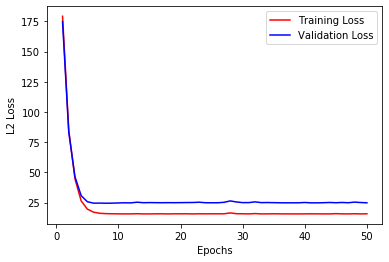


Training Loss :  15.6594500811529

Validation Loss :  24.774638914729202


In [159]:
# Define and train the Deep Neural Network.

model = Deep_Neural_Network()

model.create(2,1,[10,20],output_type='regression',activation='linear',initializer='random')

costs = model.train(X_train.T,Y_train,X_val.T,Y_val,optimizer='vanilla',regularizer='l2',
                    regularizer_lambda=0.1,mini_batch_size=32,epochs=50,print_loss_freq=10,
                    learning_rate=0.0002)

In [160]:
# Predict output for test dataset.

Y_p = model.predict(X_test.T)

In [161]:
# Calculate Loss for test dataset

print(model.compute_cost(Y_p,Y_test.reshape(1,102)))

13.316447122757625


After 10 epochs :    Training Loss = 248.73179294342202    Validation Loss = 239.42917228289122

After 20 epochs :    Training Loss = 218.72488942772432    Validation Loss = 211.00192896054907

After 30 epochs :    Training Loss = 193.55126882532406    Validation Loss = 187.15131635348544

After 40 epochs :    Training Loss = 171.24002396619525    Validation Loss = 166.12090320188258

After 50 epochs :    Training Loss = 151.99380108511122    Validation Loss = 147.9557330502878



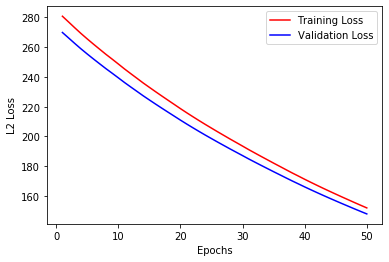


Training Loss :  151.99380108511122

Validation Loss :  147.9557330502878


In [156]:
model_bis = Deep_Neural_Network()

model_bis.create(2,1,[10,20],output_type='regression',activation='linear',initializer='random')

costs = model_bis.train(X_train.T,Y_train,X_val.T,Y_val,optimizer='vanilla',regularizer='l2',
                    regularizer_lambda=0.1,mini_batch_size=32,epochs=50,print_loss_freq=10,
                    learning_rate=0.000002)

In [157]:
# Predict output for test dataset.

Y_p_bis = model_bis.predict(X_test.T)

# Calculate Loss for test dataset

print(model_bis.compute_cost(Y_p_bis,Y_test.reshape(1,102)))

159.11456395039997


After 10 epochs :    Training Loss = 25.775802569891727    Validation Loss = 36.385063844330766

After 20 epochs :    Training Loss = 35.35180320962906    Validation Loss = 50.747128651210154

After 30 epochs :    Training Loss = 16.003213585289018    Validation Loss = 25.405747937839855

After 40 epochs :    Training Loss = 16.351517452982165    Validation Loss = 26.069333402919614

After 50 epochs :    Training Loss = 16.5993724418392    Validation Loss = 26.381420867416278



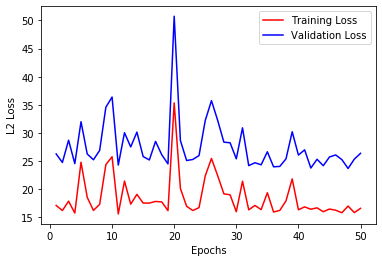


Training Loss :  16.5993724418392

Validation Loss :  26.381420867416278


In [177]:
model_bis = Deep_Neural_Network()

model_bis.create(2,1,[10,20],output_type='regression',activation='linear',initializer='random')

costs = model_bis.train(X_train.T,Y_train,X_val.T,Y_val,optimizer='vanilla',regularizer='l2',
                    regularizer_lambda=0.1,mini_batch_size=32,epochs=50,print_loss_freq=10,
                    learning_rate=0.004)

In [178]:
# Predict output for test dataset.

Y_p_bis = model_bis.predict(X_test.T)

# Calculate Loss for test dataset

print(model_bis.compute_cost(Y_p_bis,Y_test.reshape(1,102)))

14.599649464609508


After 10 epochs :    Training Loss = 15.590774261006754    Validation Loss = 25.095743029761223

After 20 epochs :    Training Loss = 15.545168152220022    Validation Loss = 24.83559966422296

After 30 epochs :    Training Loss = 15.55700151543586    Validation Loss = 24.94331087696384

After 40 epochs :    Training Loss = 15.576984905337186    Validation Loss = 24.954597475708717

After 50 epochs :    Training Loss = 15.547026593947662    Validation Loss = 24.7257784602743



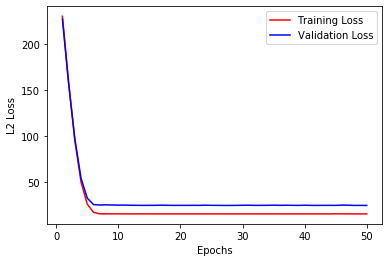


Training Loss :  15.547026593947662

Validation Loss :  24.7257784602743


In [182]:
# Define and train the Deep Neural Network.

model = Deep_Neural_Network()

model.create(2,1,[10,20],output_type='regression',activation='linear',initializer='random')

costs = model.train(X_train.T,Y_train,X_val.T,Y_val,optimizer='momentum',regularizer='l2',
                    regularizer_lambda=0.1,mini_batch_size=32,epochs=50,print_loss_freq=10,
                    learning_rate=0.0002)

After 10 epochs :    Training Loss = 259.5837310408425    Validation Loss = 246.93326912346708

After 20 epochs :    Training Loss = 216.11516038138151    Validation Loss = 207.94155797593717

After 30 epochs :    Training Loss = 185.3890909746388    Validation Loss = 180.18316915963825

After 40 epochs :    Training Loss = 157.92161812405337    Validation Loss = 154.62755721278936

After 50 epochs :    Training Loss = 131.0720100802139    Validation Loss = 129.32382131136785



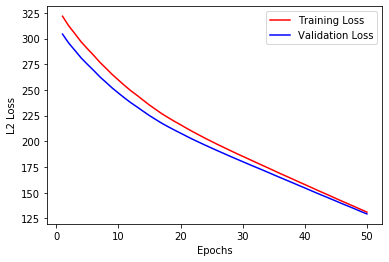


Training Loss :  131.0720100802139

Validation Loss :  129.32382131136785


In [180]:
# Define and train the Deep Neural Network.

model = Deep_Neural_Network()

model.create(2,1,[10,20],output_type='regression',activation='linear',initializer='random')

costs = model.train(X_train.T,Y_train,X_val.T,Y_val,optimizer='rmsprop',regularizer='l2',
                    regularizer_lambda=0.1,mini_batch_size=32,epochs=50,print_loss_freq=10,
                    learning_rate=0.0002)

After 10 epochs :    Training Loss = 242.69588489532214    Validation Loss = 237.81259351008077

After 20 epochs :    Training Loss = 222.42150796923602    Validation Loss = 218.14453863569184

After 30 epochs :    Training Loss = 203.43150493376916    Validation Loss = 199.49452962460342

After 40 epochs :    Training Loss = 184.04433420054949    Validation Loss = 180.82506280882393

After 50 epochs :    Training Loss = 164.02428414168946    Validation Loss = 161.4196645259307



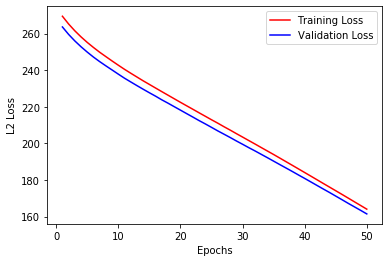


Training Loss :  164.02428414168946

Validation Loss :  161.4196645259307


In [181]:
# Define and train the Deep Neural Network.

model = Deep_Neural_Network()

model.create(2,1,[10,20],output_type='regression',activation='linear',initializer='random')

costs = model.train(X_train.T,Y_train,X_val.T,Y_val,optimizer='adam',regularizer='l2',
                    regularizer_lambda=0.1,mini_batch_size=32,epochs=50,print_loss_freq=10,
                    learning_rate=0.0002)

After 100 epochs :    Training Loss = 8.748501056845164    Validation Loss = 12.468850772190477

After 200 epochs :    Training Loss = 8.514733665958426    Validation Loss = 13.603085979981662

After 300 epochs :    Training Loss = 8.521212617921126    Validation Loss = 14.060143128207176

After 400 epochs :    Training Loss = 8.519955411255774    Validation Loss = 14.109214350148497

After 500 epochs :    Training Loss = 8.595830343738582    Validation Loss = 14.474171885412972



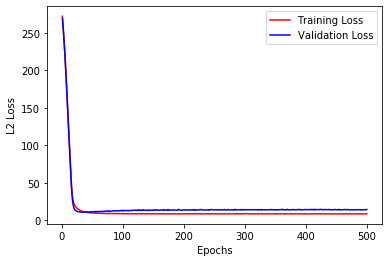


Training Loss :  8.595830343738582

Validation Loss :  14.474171885412972


In [189]:
# Define and train the Deep Neural Network.

model = Deep_Neural_Network()

model.create(2,1,[10,20],output_type='regression',activation='relu',initializer='he')

costs = model.train(X_train.T,Y_train,X_val.T,Y_val,optimizer='rmsprop',regularizer='l2',
                    regularizer_lambda=0.1,mini_batch_size=32,epochs = 500,print_loss_freq=100,
                    learning_rate=0.002)

After 10 epochs :    Training Loss = 15.161630246349372    Validation Loss = 37.146790127140285



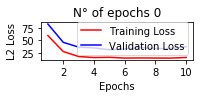


Training Loss :  15.161630246349372

Validation Loss :  37.146790127140285
After 10 epochs :    Training Loss = 14.678728491356738    Validation Loss = 34.25521684633825

After 20 epochs :    Training Loss = 14.02873965281457    Validation Loss = 33.189655512377925

After 30 epochs :    Training Loss = 14.00286952118115    Validation Loss = 33.78919887965848

After 40 epochs :    Training Loss = 14.739779233790625    Validation Loss = 34.581200274499075

After 50 epochs :    Training Loss = 14.611142457527935    Validation Loss = 32.7684932293636



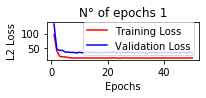


Training Loss :  14.611142457527935

Validation Loss :  32.7684932293636
After 10 epochs :    Training Loss = 14.701045394659369    Validation Loss = 36.449620088181995

After 20 epochs :    Training Loss = 14.6530927884082    Validation Loss = 36.699425639919866

After 30 epochs :    Training Loss = 14.190813489078055    Validation Loss = 35.353565589208365

After 40 epochs :    Training Loss = 14.031261328531816    Validation Loss = 33.34647023230213

After 50 epochs :    Training Loss = 14.632527720239954    Validation Loss = 31.90945413659658

After 60 epochs :    Training Loss = 13.936027232726335    Validation Loss = 31.875127482135934

After 70 epochs :    Training Loss = 14.208485496512152    Validation Loss = 30.881996520621833

After 80 epochs :    Training Loss = 14.072000983308437    Validation Loss = 33.004145687845266

After 90 epochs :    Training Loss = 14.935533265833698    Validation Loss = 31.91073626364912

After 100 epochs :    Training Loss = 14.379727486376629  

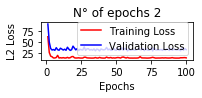


Training Loss :  14.379727486376629

Validation Loss :  33.17040264893021
After 10 epochs :    Training Loss = 13.966966045401005    Validation Loss = 32.88125239805038

After 20 epochs :    Training Loss = 14.135885222041095    Validation Loss = 34.551126626042574

After 30 epochs :    Training Loss = 13.908465707358332    Validation Loss = 33.160649953345725

After 40 epochs :    Training Loss = 14.017081494588489    Validation Loss = 32.261345656520476

After 50 epochs :    Training Loss = 13.921694340730351    Validation Loss = 33.32588400164676

After 60 epochs :    Training Loss = 14.36996296346232    Validation Loss = 34.88714199047614

After 70 epochs :    Training Loss = 13.924573987876496    Validation Loss = 33.646398573687286

After 80 epochs :    Training Loss = 14.120291642184277    Validation Loss = 32.0687027956366

After 90 epochs :    Training Loss = 14.117729185864608    Validation Loss = 33.72399455114557

After 100 epochs :    Training Loss = 13.90753442530674    

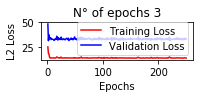


Training Loss :  13.876817493620344

Validation Loss :  33.22139242115239
After 10 epochs :    Training Loss = 17.660788598638533    Validation Loss = 43.075689282843314

After 20 epochs :    Training Loss = 13.880985686633075    Validation Loss = 32.61197903074128

After 30 epochs :    Training Loss = 13.873640354712153    Validation Loss = 33.033564372429

After 40 epochs :    Training Loss = 14.502529678767027    Validation Loss = 30.45328757019561

After 50 epochs :    Training Loss = 15.345426699119445    Validation Loss = 32.50876185371101

After 60 epochs :    Training Loss = 14.093672732823169    Validation Loss = 33.92169553547597

After 70 epochs :    Training Loss = 16.118214066793122    Validation Loss = 30.769271793566116

After 80 epochs :    Training Loss = 14.016591101117399    Validation Loss = 31.73911630418819

After 90 epochs :    Training Loss = 13.949605559673714    Validation Loss = 32.46775809764812

After 100 epochs :    Training Loss = 15.587720149149428    V

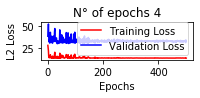


Training Loss :  13.875568767983737

Validation Loss :  33.10709844494655
After 10 epochs :    Training Loss = 13.970391256470647    Validation Loss = 34.316768071448166

After 20 epochs :    Training Loss = 14.355815589632176    Validation Loss = 32.46412419998499

After 30 epochs :    Training Loss = 14.066442383741693    Validation Loss = 34.11439455505052

After 40 epochs :    Training Loss = 13.936057435982521    Validation Loss = 33.860135749400186

After 50 epochs :    Training Loss = 14.077215172085566    Validation Loss = 34.886053835310896

After 60 epochs :    Training Loss = 14.289941781379822    Validation Loss = 34.238060695165316

After 70 epochs :    Training Loss = 13.912646047002811    Validation Loss = 33.47071725839711

After 80 epochs :    Training Loss = 13.905058338978655    Validation Loss = 33.34058224990573

After 90 epochs :    Training Loss = 13.919609490744252    Validation Loss = 33.95403902946324

After 100 epochs :    Training Loss = 14.361184181778757 

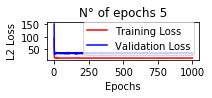


Training Loss :  13.91788779504703

Validation Loss :  32.308238097876654
After 10 epochs :    Training Loss = 14.002054191710556    Validation Loss = 32.74832704462904

After 20 epochs :    Training Loss = 14.024799069122224    Validation Loss = 32.07161899760887

After 30 epochs :    Training Loss = 14.118348952309626    Validation Loss = 33.998687049991275

After 40 epochs :    Training Loss = 13.922381601950997    Validation Loss = 33.84214467617177

After 50 epochs :    Training Loss = 14.051469168441246    Validation Loss = 33.53531793303084

After 60 epochs :    Training Loss = 14.254972965884404    Validation Loss = 35.32628050988029

After 70 epochs :    Training Loss = 14.273217468012376    Validation Loss = 32.84735986258725

After 80 epochs :    Training Loss = 14.52755758393777    Validation Loss = 35.070465513107536

After 90 epochs :    Training Loss = 13.893973162683382    Validation Loss = 33.11437595391728

After 100 epochs :    Training Loss = 13.909479486321466    

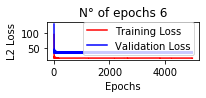


Training Loss :  13.896680114526635

Validation Loss :  32.76815785806646


In [91]:
n_epochs = [10, 50, 100, 250, 500, 1000, 5000]
for i in range(len(n_epochs)):
    plt.subplot(5, 2, i+1)
    plt.title('N° of epochs %d' % i)
    ep = n_epochs[i]
    
    Model = Deep_Neural_Network()

    Model.create(2,1,[10,20],output_type='regression',activation='linear',initializer='random')

    costs = Model.train(X_train.T,Y_train,X_val.T,Y_val,optimizer='momentum',regularizer=None,
                    regularizer_lambda=0.1,mini_batch_size=32,epochs=ep,print_loss_freq=10,
                    learning_rate=0.002)
plt.show()

In [120]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

(X, Y), (X_test, Y_test) = boston_housing.load_data()
X = X[:,[5,12]]
X_test = X_test[:,[5,12]]

X_train,X_val,Y_train,Y_val = train_test_split(X,Y,test_size=0.1)
X_train = (X_train-np.mean(X_train,axis=0))/np.std(X_train,axis=0)
X_test = (X_test-np.mean(X_test,axis=0))/np.std(X_test,axis=0)

linreg = LinearRegression()
linreg.fit(X_train, Y_train)

pred_sk = linreg.predict(X_test)
metrics.mean_squared_error(Y_test, pred_sk)

24.881186102710448